In [1]:
from IPython.core.display import HTML

# Estimating the Hurst Exponent

### Robert Simpson
### April 5, 2020

###  Method

The Hurst exponent is generally measured rescaled-range analysis conducted upon several time spans within a series. The mean value of the rescaled ranges of a given time span is dependent upon the length of the time span itself. Thuse we can fit it to a power-law described below. It is the power which we call the Hurst exponent.

Let $X_{N}$ be a time series of length $N$. This time Series can be 'chopped up' into partial time series of varying sub-lengths. Generally it has been suggested to do this in powers of $2$ although it isn't necessary to do so.

Let $\bar{X}_{n}$ be a partial time series of length $n \leq N$. We now have many time series from our single original time-series. For example if our original time series were of length $1000$. We can produce $500$ time series of length $500$ just be shifting over one observation ($[x_{0},...,x_{499}]$; $[x_{1},...,x_{500}]$;...$[x_{500},...,x_{999}]$). 

Now we need to find the range of the cuulative deviate series of each partial time-series recentered about the mean:

$$
Y_{n} = \bar{X}_{n} - \mathbb{E}[\bar{X}_{n}]
$$

$$
Z_{t} = \sum^{t}_{i=1} Y_{i} , t= 1,2,3...,n
$$

$$
R(n) = \max[Z_{1}, Z_{2},...,Z_{n}] - \min[Z_{1}, Z_{2},...,Z_{n}]
$$

$$
S(n) = \sqrt{\frac{1}{n}\sum^{n}_{i=1} (\bar{X_{n}}  - \mathbb{E}[\bar{X}_{n}]})^2
$$

Taking all the time series of equal length we can then find:

$$
\mathbb{E}\left[\frac{R(n)}{S(n)} \right]
$$

We can then fit the line: 

$$
\mathbb{E}\left[\frac{R(n)}{S(n)} \right] = Cn^{H}
$$

Where $H$ is known as the Hurst Exponent, a measure of memory in the time series.

In [2]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Estimating the Hurst Exponent

# Below we have two data makers, one wich just shows changes from the previos point, and the other which represents a
# cumulative sum of those data points. This produces a brownian motion which can serve as a benchmark to evaluate the 
# the hurst estimator. Brownian motion has a known Hurst exponent of 0.5.


def func(x, h, c):
    yData = h*x +c
    return yData

def random_data_maker(npoints):
    data = np.random.randn(npoints)
    return data

def random__cumsum_data_maker(npoints):
    data = np.cumsum(np.random.randn(npoints))
    return data

In [4]:
def hurstEstimator(data, maximumtimespan, cumulative, graph):
    
    if cumulative == True:
        data = data[1:len(data)] - data[0:len(data)-1]
    else:
        data = data
        
    segmentLengths = np.arange(10,np.floor(len(data)/(maximumtimespan)))
    expectedRescaledRange = np.zeros(len(segmentLengths))

    i = 0
    for j in segmentLengths:
        rescaledRange = np.zeros(len(data)+1 - int(j))
        #i, = np.where(segmentLengths == j)
        for t in range(len(data)+1 - int(j)):
            start = t
            end = t+ int(j)
            recentedData = data[start:end] - np.mean(data[start:end])
            Z = np.cumsum(recentedData)
            deviateSeriesRange = np.ptp(Z)
            standardDeviation = np.std(data[start:end])
            rescaledRange[t] = deviateSeriesRange/standardDeviation
        expectedRescaledRange[i] = np.mean(rescaledRange)
        i+=1

    xdata = np.log2(np.flip(segmentLengths))
    ydata = np.log2(np.flip(expectedRescaledRange))
    
    
    popt, pcov = curve_fit(func,xdata, ydata)
    perr = np.sqrt(np.diag(pcov))
    #print("The estimated Hurst Exponent is %2f"%  popt[0])
    #print("The estimated one standard deviation error is %2f" %perr[0])
    

    if graph == True:
        plt.figure(figsize=(10,8))
        plt.subplot(212)
        plt.scatter(xdata,ydata, label='Estimated Rescaled Range Values ')
        plt.plot(xdata,func(xdata,*popt),'r--',label='Least Squares Regression')
        plt.xlabel('log(n)')
        plt.ylabel('log(R/S)')
        plt.title('Rescaled Ranges')
        plt.legend()
    
        plt.subplot(221)
        plt.plot(data)
        plt.title('Data')
        plt.xlabel('t')
        plt.ylabel('$X$')
    
        plt.subplot(222)
        plt.plot(np.cumsum(data))
        plt.xlabel('t')
        plt.ylabel('Cumulative Sum of X')
        plt.title('Cumulative Sum of Data')
        
    return popt[0]

0.6296454679959728

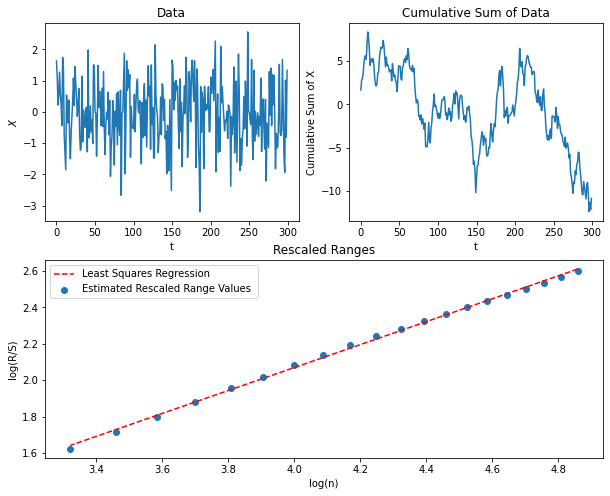

In [5]:
dd = (random_data_maker(300))
hurstEstimator(dd, 10, cumulative = False, graph=True)

We can see above in the regression we get a slight tapering off for very large n values. The memory wears off given large enough n and the system begins to look truly random again. Thus to get a better estimate of $H$ we may fit the regression to only those n-values showing an obvious slope before the tapering off. Above we expected a Hurst exponent of $0.5$. The estimator gave us $0.4917$ which is a fairly close estimate. If we were evaluating empirical data we could tentatively say the data is the product of a random process(Brownian motion).

## Financial Time Series

Although the Hurst exponent was first used in the study of Hydrology by Edwin Hurst who was analyzing the floods of the Nile river, it's use in finance was popularized by Benoit Mandelbrot who used the Hurst exponent to decsribe the behavior of stock prices. In the 1990's the Hurst exponent was popularized by Peter Edgars who developed the Fractal Market Hypothesis which was largely inspired by Mandelbrot's work.

The Hurst exponent tells whether a time series in general is random, persistent, or antipersistent. 

A random time-series will have a Hust exponent of $0.5$.

A persistent time-series will have a Hurst exponent H, $0.5<H<1$.

A anti-persistent time-series will have a Hurst exponent H, $0<H<0.5$.

Time series which are persistent will continue to increase if they have just increased, and will decrease provided the last movement was a decrease. They have momentum. Anti-persistence is precisely the opposite. An increase will encourage decrease and vice-versa. 

Stock prices generally have persistence, but may have differing degrees of persistence. If we're interested in day-trading or even long-term investing this may inform us of future probablities in regards to stocks. We should note that long-memory is infact finite. The larger the time-span considered the more the memory fade. In the long run time-series begin to look as to behave random. The Hurst exponent tends towards $0.5$.

# S&P500

The following data is sourced from the Federal Reserve Economic Database(FRED) who obtained the information directly from Standard and Poor. The S&P500 is a weighted financial indicator of the largest 500 companies on the United States stock exchange. Price changes in the stocks of larger companies will have a greater impact on the index value. Let's estimate the Hurst exponent. 

The data can be found below in the works-cited.

0.5774599062074071

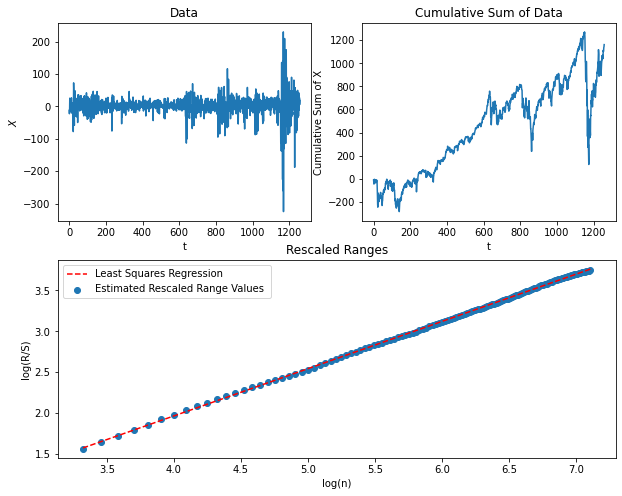

In [6]:
SP500 = pd.read_csv("C:/Users/Robert/PycharmProjects/NetworkTheory/SP500.csv")
SP500['Value'] = pd.to_numeric(SP500['SP500'],errors='coerce')
SP500 = SP500.dropna()
SP500 = SP500.Value.to_numpy()
hurstEstimator(SP500, 9, cumulative=True, graph=True)

We see that we've estimated the Hurst index to be approximately $0.577$ with a standard deviation error of $0.0008$. We can be fairly sure then given the time frame shown that the S&P500 is somewhat persistent, that is that upward movement begets upward movement and downawrd movement begets downward movement. 

### More Stocks!

However we may want to examine stocks unaggregated so let's look at a few. For this I"ll be using yfinance, accessing yahoo's stock API.

In [9]:
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override() 


stocks = ("MSFT","AAPL","T","DDD","JNJ","KO","Pep","MCD", "AA", "XOM", "GOOG", "AMZN")
stocks = sorted(stocks)
ST = ' '.join(stocks)

data = yf.download(ST, start="2000-01-01", end="2017-04-30", index = stocks)
data = data['Close']
print(data.head())

[*********************100%***********************]  12 of 12 completed
                    AA      AAPL     AMZN       DDD  GOOG       JNJ        KO  \
Date                                                                            
2000-01-03   96.840897  0.999442  89.3750  2.750000   NaN  46.09375  28.18750   
2000-01-04   97.561798  0.915179  81.9375  2.625000   NaN  44.40625  28.21875   
2000-01-05  103.329002  0.928571  69.7500  2.770833   NaN  44.87500  28.46875   
2000-01-06  101.598839  0.848214  65.5625  2.750000   NaN  46.28125  28.50000   
2000-01-07  101.406601  0.888393  69.5625  2.916667   NaN  48.25000  30.37500   

                MCD      MSFT      PEP        T       XOM  
Date                                                       
2000-01-03  39.6250  58.28125  36.8750  47.0000  39.15625  
2000-01-04  38.8125  56.31250  35.9375  44.2500  38.40625  
2000-01-05  39.4375  56.90625  35.0625  44.9375  40.50000  
2000-01-06  38.8750  55.00000  36.6250  43.7500  42.59375  
2

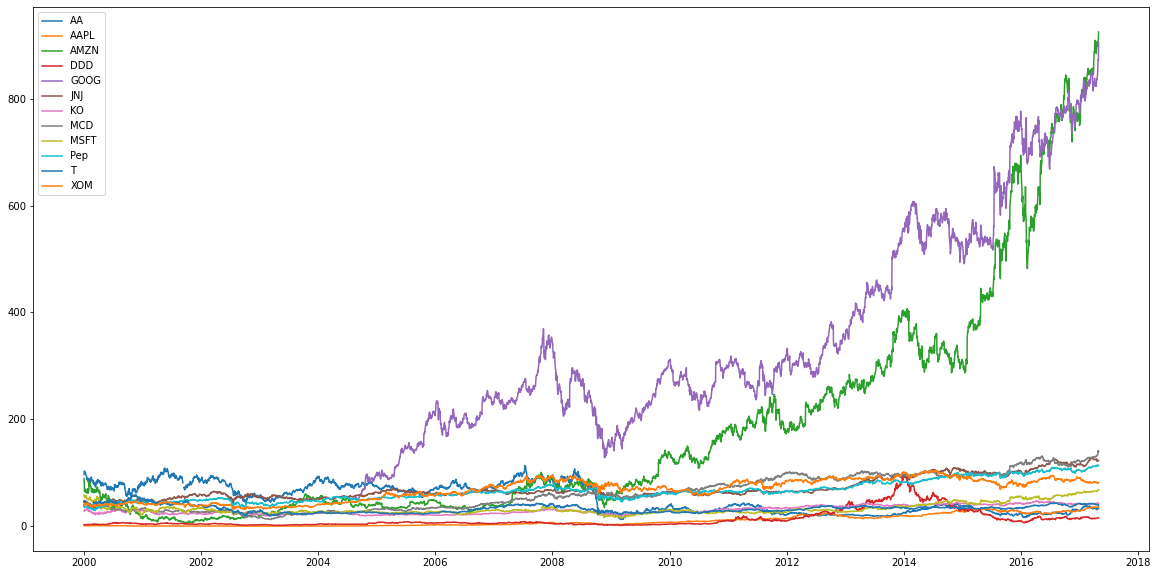

In [10]:
plt.figure(figsize=(20,10))
plt.plot(data,linestyle = '-',)
plt.legend(stocks)

In [ ]:
hurstValues = np.zeros((len(data.columns),1))
for i in range(len(data.columns)):
    xx = data.iloc[:,[i]]
    xx = xx.dropna()
    xx = xx.to_numpy()
    hurstValues[i] = hurstEstimator(xx,10,cumulative=True, graph=False)

In [ ]:
hurstValues = hurstValues.flatten()
yy = range(len(hurstValues))
plt.figure(figsize=(10,2))
plt.bar(yy,hurstValues, color = 'c', log=True, width=0.8)
plt.axhline(y=0.5, color='r', linestyle='-')
ax = plt.gca()
ax.set_xticks(yy)
ax.set_xticklabels(stocks)
plt.title('Estimated Hurst Exponents')

$\newcommand{\E}{\mathrm{E}}$
$\newcommand{\Var}{\mathrm{Var}}$
$\newcommand{\Cov}{\mathrm{Cov}}$
We can see over the 10 year period there is a range of hurst exponents among the stocks and the hurst expoenent estimated isn't easily seen by just examining the graph alone. We see that Apple and Alcoa stocks have the two highest hurst exponents exhibiting very heavy persistence. On the low end we see Pepsi, AT&R, and Exxon exhibiting anti-persistence. What causes this difference? 

Prima facie XOM, T, Pep are heavy dividend stocks. As of April 11,2020 they have dividend yields of 8%, 6.77%, and 2.86% respectively. So XOM has a below average dividend yield, but is still very anti persistent. So dividend yields do not necessarily explain the Hurst expoenent especially when we condsider JNJ and KO which area also very beloved by divdend minded investors.

How does the Hurst exponent compares to other measures, say Beta for instance. Beta is the statistical measure of a given stock that measures how changes in stock price correlate to changes in the overall market. 


$$
\beta = \frac{\Cov(\Delta \Gamma, \Delta \gamma)}{\Var(\Delta \Gamma)}
$$

$\Gamma$ is the price of the aggregate market index and $gamma$ is the individual stock.

$\beta$ can change over time (more on that later) just like the hurst exponent so we'll want to estimate it for the period above.

In [12]:
def beta(market,stock):
    covariance = np.cov(market, stock, ddof=0)[0][1]
    marketVariance = np.var(market)
    B = covariance/marketVariance
    return B 

In [14]:
print(data)

                    AA       AAPL        AMZN        DDD        GOOG  \
Date                                                                   
2000-01-03   96.840897   0.999442   89.375000   2.750000         NaN   
2000-01-04   97.561798   0.915179   81.937500   2.625000         NaN   
2000-01-05  103.329002   0.928571   69.750000   2.770833         NaN   
2000-01-06  101.598839   0.848214   65.562500   2.750000         NaN   
2000-01-07  101.406601   0.888393   69.562500   2.916667         NaN   
...                ...        ...         ...        ...         ...   
2017-04-24   33.310001  35.910000  907.409973  15.400000  862.760010   
2017-04-25   36.490002  36.132500  907.619995  15.590000  872.299988   
2017-04-26   36.450001  35.919998  909.289978  15.870000  871.729980   
2017-04-27   34.520000  35.947498  918.380005  15.850000  874.250000   
2017-04-28   33.730000  35.912498  924.989990  15.830000  905.960022   

                   JNJ         KO         MCD       MSFT       

In [30]:
#We may want to see if there is a relationship between RSI and a windowed Hurst Exponent
def RSI (data, time_window):
    diff = data.diff(1).dropna()        # diff in one field(one day)
    up_chg = 0 * diff
    down_chg = 0 * diff
    up_chg[diff > 0] = diff[ diff>0 ]
    down_chg[diff < 0] = diff[ diff < 0 ]

    up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi

Text(0.5, 1.0, 'Price of Apple Shares')

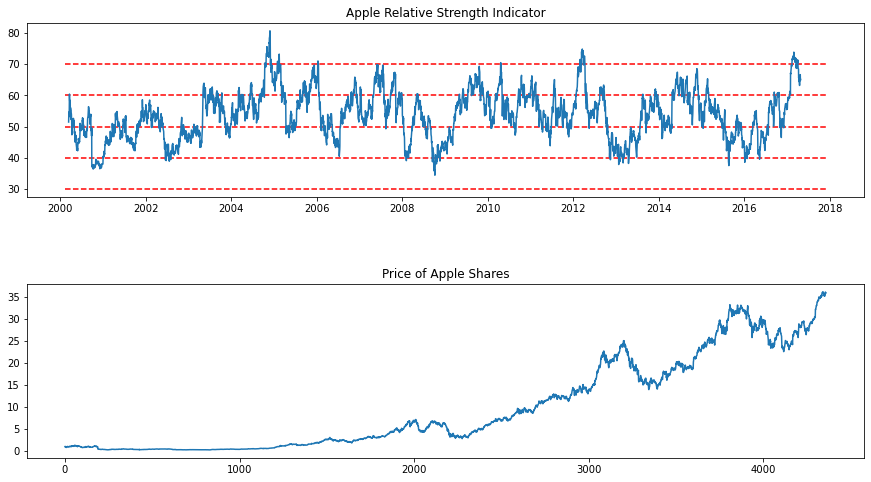

In [86]:

AA = data.iloc[:,1]
AAA = RSI(AA,50)
fig = plt.figure(figsize = (15,8))
plt.subplots_adjust(hspace=0.5)
plt.subplot(211)
plt.plot(AAA)
plt.hlines(y=50, xmin =11000, xmax=17500, colors='r', linestyles = '--')
plt.hlines(y=30, xmin =11000, xmax=17500, colors='r', linestyles = '--')
plt.hlines(y=70, xmin =11000, xmax=17500, colors='r', linestyles = '--')
plt.hlines(y=60, xmin =11000, xmax=17500, colors='r', linestyles = '--')
plt.hlines(y=40, xmin =11000, xmax=17500, colors='r', linestyles = '--')
plt.title('Apple Relative Strength Indicator')
plt.subplot(212)
plt.plot(AA.to_numpy())
plt.title('Price of Apple Shares')

### Works Cited

Mandelbrot, Benoit 2001c. Scaling in financial prices, III: Cartoon Brownian motions inmultifractal time. Quantitative Finance:  1, 427-440.

Mandelbrot,  Benoit  1963b.  The  variation  of  certain  speculative  prices.  The  Journal  ofBusiness of the University of Chicago:  36, 394-419

Mandelbrot, Benoit. The Misbehavior of Markets. Basic Books. 2006

Peters, Edgar. Fractal Market Analysis. Wiley. 1994


S&P Dow Jones Indices LLC, S&P 500 [SP500], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/SP500, April 5, 2020.